In [1]:
#

from matplotlib import pyplot as plt

import numpy as np
from scipy.linalg import svd, eigh

import pandas as pd

import os

import cv2

import random

from sklearn.decomposition import PCA


import sys
sys.path.append('../scripts/')

import flag_dimensionality_reduction as fdr

from sklearn.metrics import roc_curve, auc

import time

def get_data(class_name, n_pts):
    data = []
    for i in np.arange(n_pts):
        if i < 10:
            im_num = f'0{i}'
        else:
            im_num = str(i)
        image = plt.imread(f'./UCMerced_LandUse/Images/{class_name}/{class_name}{im_num}.tif')
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        small_gray_image = cv2.resize(gray_image, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
        data.append(small_gray_image.flatten())

    return data

def get_outliers(class_name, n_pts, seed):
    np.random.seed(seed)
    data = []
    for i in np.random.choice(100, n_pts, replace = False):
        if i < 10:
            im_num = f'0{i}'
        else:
            im_num = str(i)
        image = plt.imread(f'./UCMerced_LandUse/Images/{class_name}/{class_name}{im_num}.tif')
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        small_gray_image = cv2.resize(gray_image, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
        data.append(small_gray_image.flatten())

    return data


In [2]:
n_in = 100
n_out = 20
inliers = get_data('runway', n_in)
outliers = get_outliers('mobilehomepark', n_out, 0)

X_raw = np.vstack([inliers, outliers])

pca = PCA(n_components = 50)
X = pca.fit_transform(X_raw)

column_means = np.mean(X, axis=0)
Xcenter = X - column_means

labels = np.array([0]*n_in+[1]*n_out)

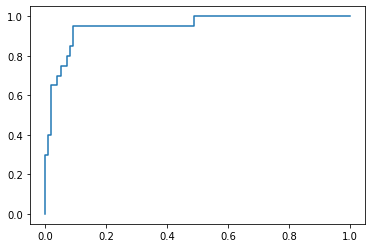

In [3]:
pca = PCA(n_components = 10)
pca.fit(Xcenter)
Wpca = pca.components_.T

pca_errs = []
for i in range(len(X_raw)):   
    x = Xcenter[[i],:]
    pca_errs.append(np.linalg.norm(x @ Wpca @ Wpca.T  - x))
    
pca_preds = np.array(pca_errs)
pca_preds = pca_preds/np.max(pca_preds)


fpr, tpr, _ = roc_curve(labels, pca_preds, drop_intermediate=False)
plt.plot(fpr, tpr)

In [4]:
def man_RPCA(Y: np.array, n_pcs = 10):
    '''
        trying to code alg1 in python
        https://jmlr.csail.mit.edu/papers/volume19/17-473/17-473.pdf
    '''
    

    pca = PCA(n_components = n_pcs)
    pca.fit_transform(Y.T)
    W = pca.components_.T
    L0 = W @ W.T @ Y

    n,p = L0.shape
    print(L0.shape)

    gamma = .1
    eta = .7

    row_idx = int(np.ceil((p-1)*(1-gamma)))
    col_idx = int(np.ceil((n-1)*(1-gamma)))
    

    diff = 1
    while diff  > 1e-10:

        U, S, V = np.linalg.svd(L0)

        L0mY = L0 - Y
        D = np.zeros(L0.shape)
        for i in range(n):
            sorted_row = np.sort(np.abs(L0mY[i,:]))
            row_thresh = sorted_row[row_idx]
            for j in range(p):
                sorted_col = np.sort(np.abs(L0mY[:,j]))
                col_thresh = sorted_col[col_idx]
                if L0mY[i,j] > row_thresh and L0mY[i,j] > col_thresh:
                    D[i,j] = 0
                else:
                    D[i,j] = L0mY[i,j]

        Pu = U @ U.T
        Pv = V @ V.T
        Omega = Pu @ D + D @ Pv - Pu @ D @ Pv

        L1 = L0 - eta*Omega

        diff = np.linalg.norm(L1 - L0)
        # print(np.linalg.norm(L1, ord = 'nuc') + np.linalg.norm(Xcenter - L1))
        # print(.5*np.linalg.norm(D,ord = 'fro')**2)

        L0 = L1.copy()

    return L1

(50, 120)


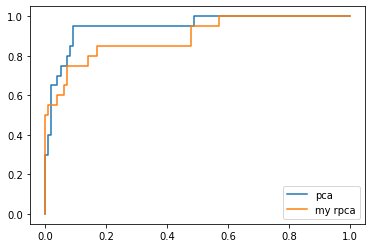

In [5]:
Xhat = man_RPCA(Xcenter.T)
pca_errs = []
for i in range(len(X)):   
    pca_errs.append(np.linalg.norm(Xhat[:,i]  - Xcenter[i,:]))

rpca_preds = np.array(pca_errs)
rpca_preds = rpca_preds/np.max(rpca_preds)

fpr, tpr, _ = roc_curve(labels, pca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'pca')

fpr, tpr, _ = roc_curve(labels, rpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'my rpca')

plt.legend()

In [6]:
import math
import numpy.linalg

def robust_pca(M):
    #https://github.com/nwbirnie/rpca/blob/master/rpca.py
    """ 
    Decompose a matrix into low rank and sparse components.
    Computes the RPCA decomposition using Alternating Lagrangian Multipliers.
    Returns L,S the low rank and sparse components respectively
    """
    L = numpy.zeros(M.shape)
    S = numpy.zeros(M.shape)
    Y = numpy.zeros(M.shape)
    # print(M.shape)
    mu = (M.shape[0] * M.shape[1]) / (4.0 * L1Norm(M))
    lamb = max(M.shape) ** -0.5
    while not converged(M,L,S):
        L = svd_shrink(M - S - (mu**-1) * Y, mu)
        S = shrink(M - L + (mu**-1) * Y, lamb * mu)
        Y = Y + mu * (M - L - S)
    return L,S
    
def svd_shrink(X, tau):
    """
    Apply the shrinkage operator to the singular values obtained from the SVD of X.
    The parameter tau is used as the scaling parameter to the shrink function.
    Returns the matrix obtained by computing U * shrink(s) * V where 
        U are the left singular vectors of X
        V are the right singular vectors of X
        s are the singular values as a diagonal matrix
    """
    U,s,V = numpy.linalg.svd(X, full_matrices=False)
    return numpy.dot(U, numpy.dot(numpy.diag(shrink(s, tau)), V))
    
def shrink(X, tau):
    """
    Apply the shrinkage operator the the elements of X.
    Returns V such that V[i,j] = max(abs(X[i,j]) - tau,0).
    """
    V = numpy.copy(X).reshape(X.size)
    for i in range(V.size):
        V[i] = math.copysign(max(abs(V[i]) - tau, 0), V[i])
        if V[i] == -0:
            V[i] = 0
    return V.reshape(X.shape)
            
def frobeniusNorm(X):
    """
    Evaluate the Frobenius norm of X
    Returns sqrt(sum_i sum_j X[i,j] ^ 2)
    """
    accum = 0
    V = numpy.reshape(X,X.size)
    for i in range(V.size):
        accum += abs(V[i] ** 2)
    return math.sqrt(accum)

def L1Norm(X):
    """
    Evaluate the L1 norm of X
    Returns the max over the sum of each column of X
    """
    return max(numpy.sum(X,axis=0))

def converged(M,L,S):
    """
    A simple test of convergence based on accuracy of matrix reconstruction
    from sparse and low rank parts
    """
    error = frobeniusNorm(M - L - S) / frobeniusNorm(M)
    print(f'error = {error}')
    return error <= 10e-6


error = 1.0
error = 7.025613031694018e-06


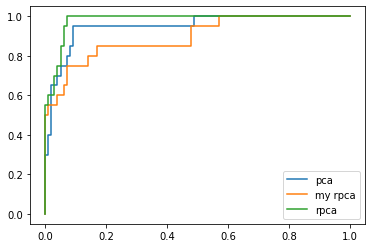

In [7]:

Xhat, S = robust_pca(Xcenter.T)

pca_errs = []
for i in range(len(X)):   
    pca_errs.append(np.linalg.norm(Xhat[:,i]  - Xcenter[i,:]))

brpca_preds = np.array(pca_errs)
brpca_preds = brpca_preds/np.max(brpca_preds)

fpr, tpr, _ = roc_curve(labels, pca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'pca')

fpr, tpr, _ = roc_curve(labels, rpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'my rpca')

fpr, tpr, _ = roc_curve(labels, brpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'rpca')

plt.legend()


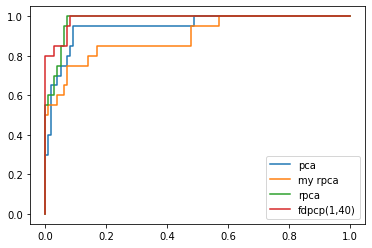

In [8]:
dpcp_preds = np.load('/Users/natemankovich/Documents/PostDoc/FunWithFlags2024/RemoteSensing/results_sanity/dpcp/preds_[1, 10]_20_t0.npy')

fpr, tpr, _ = roc_curve(labels, pca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'pca')

fpr, tpr, _ = roc_curve(labels, rpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'my rpca')

fpr, tpr, _ = roc_curve(labels, brpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'rpca')

fpr, tpr, _ = roc_curve(labels, dpcp_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'fdpcp(1,40)')

plt.legend()

In [9]:
import wpca



(-0.01, 0.2)

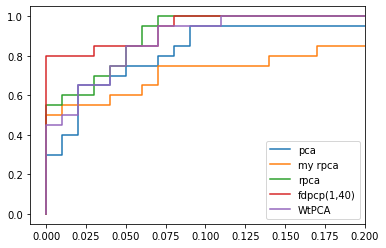

In [10]:

my_wpca = wpca.WPCA(n_components = 8)
my_wpca.fit(Xcenter)
Wwpca = my_wpca.components_.T

pca_errs = []
for i in range(len(X)):   
    x = Xcenter[[i],:]
    pca_errs.append(np.linalg.norm(x @ Wwpca @ Wwpca.T - x))

wpca_preds = np.array(pca_errs)
wpca_preds = wpca_preds/np.max(wpca_preds)

# plt.figure()
# plt.scatter(np.arange(len(wpca_preds)), wpca_preds)
# plt.scatter(np.arange(len(wpca_preds)), labels)

plt.figure()
fpr, tpr, _ = roc_curve(labels, pca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'pca')

fpr, tpr, _ = roc_curve(labels, rpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'my rpca')

fpr, tpr, _ = roc_curve(labels, brpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'rpca')

fpr, tpr, _ = roc_curve(labels, dpcp_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'fdpcp(1,40)')

fpr, tpr, _ = roc_curve(labels, wpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'WtPCA')
plt.legend()
plt.xlim([-.01,.2])

(-0.01, 0.2)

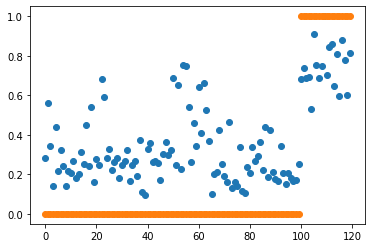

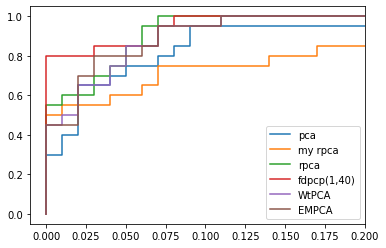

In [11]:
my_wpca = wpca.EMPCA(n_components = 8)
my_wpca.fit(Xcenter)
Wwpca = my_wpca.components_.T

pca_errs = []
for i in range(len(X)):   
    x = Xcenter[[i],:]
    pca_errs.append(np.linalg.norm(x @ Wwpca @ Wwpca.T - x))

empca_preds = np.array(pca_errs)
empca_preds = empca_preds/np.max(empca_preds)

plt.scatter(np.arange(len(wpca_preds)), empca_preds)
plt.scatter(np.arange(len(wpca_preds)), labels)

plt.figure()
fpr, tpr, _ = roc_curve(labels, pca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'pca')

fpr, tpr, _ = roc_curve(labels, rpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'my rpca')

fpr, tpr, _ = roc_curve(labels, brpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'rpca')

fpr, tpr, _ = roc_curve(labels, dpcp_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'fdpcp(1,40)')

fpr, tpr, _ = roc_curve(labels, wpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'WtPCA')

fpr, tpr, _ = roc_curve(labels, empca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'EMPCA')
plt.legend()
plt.xlim([-.01,.2])

In [25]:
#https://github.com/ktountas/L1-Norm-Algorithms/tree/master
def l1pca_sbfk(X, K, num_init, print_flag):
	# Parameters
	toler =10e-8

	# Get the dimentions of the matrix.
	dataset_matrix_size = X.shape	
	D = dataset_matrix_size[0]	# Row dimension.
	N = dataset_matrix_size[1]	# Column dimension.

	# Initialize the matrix with the SVD.
	dummy, S_x, V_x = svd(X , full_matrices = False)	# Hint: The singular values are in vector form.
	if D < N:
		V_x = V_x.transpose()
		
	X_t = np.matmul(np.diag(S_x),V_x.transpose())

	# Initialize the required matrices and vectors.
	Bprop = np.ones((N,K),dtype=float)
	nucnormmax = 0
	iterations = np.zeros((1,num_init),dtype=float)

	# For each initialization do.
	for ll in range(0, num_init):
		
		start_time = time.time()	# Start measuring execution time.

		v = np.random.randn(N,K)	# Random initialized vector.
		if ll<2:	# In the first initialization, initialize the B matrix to sign of the product of the first 
					# right singular vector of the input matrix with an all-ones matrix.
			z = np.zeros((N,1),dtype=float)
			z = V_x[:,0]
			z_x = z.reshape(N,1)
			v = np.matmul(z_x,np.ones((1,K), dtype=float))
		B = np.sign(v)	# Get a binary vector containing the signs of the elements of v.

		# Calculate the nuclear norm of X*B.
		X_temp = np.matmul(X_t,B)
		dummy1, S, dummy2 = svd(X_temp , full_matrices = False)
		nucnorm = np.sum(np.sum(np.diag(S)))
		nuckprev = nucnorm*np.ones((K,1), dtype=float)

		# While not converged bit flip.
		iter_ = 0
		while True:
			iter_ = iter_ + 1

			flag = False

			# Calculate all the possible binary vectors and all posible bit flips.
			for k in range(0, K):

				a = np.zeros((N,1), dtype=float)

				for n in range(0, N):
					B_t = B
					B_t[n,k] = -B[n,k]
					dummy1, S, dummy2 = svd(np.matmul(X_t,B), full_matrices=False)
					a[n] = sum(sum(np.diag(S)))
				
				ma = np.max(a)	# Find which binary vector and bit flips maximize the quadratic.
				if ma > nucnorm:
					nc = np.where(a == ma)
					B_t[nc[0],k] = -B_t[nc[0],k]
					nucnorm = ma

				# If the maximum quadratic is attained, stop iterating.
				if iter_ > 1 and nucnorm<nuckprev[k] + toler:
					flag = True
					break

				nuckprev[k] = nucnorm # Save the calculated nuclear norm of the current initialization.

			if flag == True:
				break

		# Find the maximum nuclear norm across all initializations.
		iterations[0,ll] = iter_
		if nucnorm > nucnormmax:
			nucnormmax = nucnorm
			Bprop = B

	# Calculate the final subspace.
	U, dummy, V = svd(np.matmul(X,Bprop), full_matrices=False)
	Uprop = U[:,0:K]
	Vprop = V[:,0:K]
	Qprop = np.matmul(Uprop,Vprop.transpose())

	end_time = time.time()	# End of execution timestamp.
	timelapse = (end_time - start_time)	# Calculate the time elapsed.

	convergence_iter = np.mean(iterations, dtype=float) # Calculate the mean iterations per initialization.
	vmax = sum(sum(abs(np.matmul(Qprop.transpose(),X))))
	
	# If print true, print execution statistics.
	if print_flag:
		print("------------------------------------------")
		print("Avg. iterations/initialization: ", (convergence_iter))
		print("Time elapsed (sec): ", (timelapse))
		print("Metric value:", vmax)
		print("------------------------------------------")

	return Qprop, Bprop, vmax



In [33]:
n_in = 100
n_out = 60
inliers = get_data('runway', n_in)
outliers = get_outliers('mobilehomepark', n_out, 0)

X_raw = np.vstack([inliers, outliers])

pca = PCA(n_components = 50)
X = pca.fit_transform(X_raw)

column_means = np.mean(X, axis=0)
Xcenter = X - column_means

labels = np.array([0]*n_in+[1]*n_out)

In [34]:
pca = PCA(n_components = 10)
pca.fit(Xcenter)
Wpca = pca.components_.T

pca_errs = []
for i in range(len(X_raw)):   
    x = Xcenter[[i],:]
    pca_errs.append(np.linalg.norm(x @ Wpca @ Wpca.T  - x))
    
pca_preds = np.array(pca_errs)
pca_preds = pca_preds/np.max(pca_preds)

In [35]:


Wrpca,_,_ = l1pca_sbfk(Xcenter.T, 10, 200, True)

pca_errs = []
for i in range(len(X)):   
    x = Xcenter[[i],:]
    pca_errs.append(np.linalg.norm(x @ Wrpca @ Wrpca.T - x))

rpca1_preds = np.array(pca_errs)
rpca1_preds = rpca1_preds/np.max(rpca1_preds)

# plt.scatter(np.arange(len(wpca_preds)), empca_preds)
# plt.scatter(np.arange(len(wpca_preds)), labels)



------------------------------------------
Avg. iterations/initialization:  2.78
Time elapsed (sec):  0.20350193977355957
Metric value: 1139260.936122975
------------------------------------------


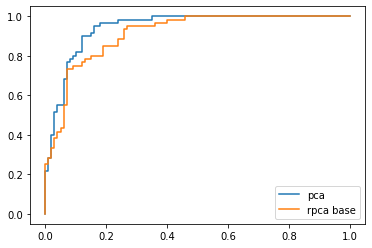

In [37]:
plt.figure()
fpr, tpr, _ = roc_curve(labels, pca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'pca')
fpr, tpr, _ = roc_curve(labels, rpca1_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'rpca base')
plt.legend()

In [12]:
import r_pca

In [13]:
my_rpca = r_pca.R_pca(Xcenter.T)

In [14]:
Lk, Sk = my_rpca.fit(max_iter=10000, iter_print=100)

iteration: 1, error: 106.35507557208575
iteration: 100, error: 0.16567282035548955
iteration: 200, error: 0.2340765729634875
iteration: 300, error: 0.39206356454608104
iteration: 400, error: 0.6301646547243499
iteration: 500, error: 0.36007933528946356
iteration: 600, error: 0.8612109434845386
iteration: 700, error: 0.6282234989243363
iteration: 800, error: 0.223987603568921
iteration: 900, error: 0.12347630870308174
iteration: 1000, error: 0.077824484244242
iteration: 1100, error: 0.05342360315191458
iteration: 1200, error: 0.09848009701602375
iteration: 1300, error: 0.06768503327929133
iteration: 1400, error: 0.03442901899529641
iteration: 1500, error: 0.04142884487679254
iteration: 1600, error: 0.028366898839895814
iteration: 1700, error: 0.03743078691997703
iteration: 1800, error: 0.02021272024573601
iteration: 1900, error: 0.02187462923040487
iteration: 2000, error: 0.015941517593462
iteration: 2100, error: 0.015439700101326344
iteration: 2200, error: 0.013825590736525865
iteratio

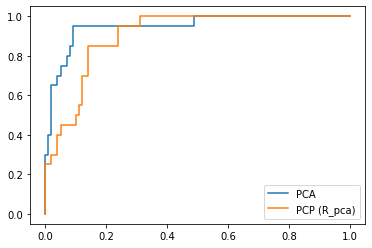

In [15]:
pca_errs = []
for i in range(len(X)):   
    pca_errs.append(np.linalg.norm(Lk[:,i]  - Xcenter[i,:]))

pcp_preds = np.array(pca_errs)
pcp_preds = pcp_preds/np.max(pcp_preds)

fpr, tpr, _ = roc_curve(labels, pca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'PCA')

fpr, tpr, _ = roc_curve(labels, pcp_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'PCP (R_pca)')
plt.legend()

iteration: 1, error: 87.93175341264006
iteration: 100, error: 0.1607858076984573
iteration: 200, error: 0.20532329552127657
iteration: 300, error: 0.26725518036753143
iteration: 400, error: 0.3338834396012913
iteration: 500, error: 0.30374028364074845
iteration: 600, error: 0.4293560044182191
iteration: 700, error: 0.2615867404760504
iteration: 800, error: 0.20406375836179355
iteration: 900, error: 0.09671568645234531
iteration: 1000, error: 0.1290998729835686
iteration: 1100, error: 0.1800846581130656
iteration: 1200, error: 0.0718915578833013
iteration: 1300, error: 0.050046108480369736
iteration: 1400, error: 0.05308291102146245
iteration: 1500, error: 0.04329989529124246
iteration: 1600, error: 0.05519708220373365
iteration: 1700, error: 0.03673923725426425
iteration: 1800, error: 0.04136849189392114
iteration: 1900, error: 0.0289677819967007
iteration: 2000, error: 0.028439551686414773
iteration: 2100, error: 0.029019673309826365
iteration: 2200, error: 0.019320660186209815
iterat

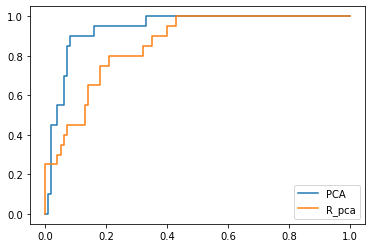

In [22]:
Xnew = Xcenter.copy()

n1, n2 = Xcenter.shape
np.random.seed(123)
S = np.random.rand(n1, n2)
Xnew[S < 0.2] = 0

pca = PCA(n_components = 10)
pca.fit(Xnew)
Wpca = pca.components_.T

pca2_errs = []
for i in range(len(X_raw)):   
    x = Xnew[[i],:]
    pca2_errs.append(np.linalg.norm(x @ Wpca @ Wpca.T  - x))
    
pca2_preds = np.array(pca2_errs)
pca2_preds = pca2_preds/np.max(pca2_preds)

plt.figure()
fpr2, tpr2, _ = roc_curve(labels, pca2_preds, drop_intermediate=False)
plt.plot(fpr2, tpr2, label = 'PCA')


my_rpca = r_pca.R_pca(Xnew.T)
Lk, Sk = my_rpca.fit(max_iter=10000, iter_print=100)

pca1_errs = []
for i in range(len(X_raw)):   
    pca1_errs.append(np.linalg.norm(Lk[:,i]  - Xnew[i,:]))
    
pca1_preds = np.array(pca1_errs)
pca1_preds = pca1_preds/np.max(pca1_preds)


fpr1, tpr1, _ = roc_curve(labels, pca1_preds, drop_intermediate=False)
plt.plot(fpr1, tpr1, label = 'R_pca')
plt.legend()

ymin: -4443.756837778099, ymax: 5575.765884419621


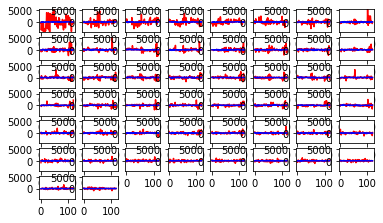

In [23]:
my_rpca.plot_fit()

iteration: 1, error: 510.42070629365554
iteration: 100, error: 8.992059473626492
iteration: 200, error: 2.137513578951175
iteration: 300, error: 1.149760848731435
iteration: 400, error: 0.5630964004817011
iteration: 500, error: 0.29687126338306524
iteration: 600, error: 0.23265662126860323
iteration: 700, error: 0.2960295324579639
iteration: 800, error: 0.35783801998523795
iteration: 900, error: 0.3786421965282994
iteration: 1000, error: 0.11027079689233546
iteration: 1100, error: 0.026629865397166542
iteration: 1200, error: 0.007213564910558505
iteration: 1238, error: 0.0044553985507882355


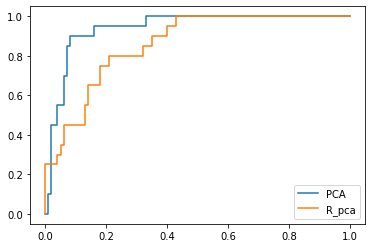

In [24]:


plt.figure()
plt.plot(fpr2, tpr2, label = 'PCA')


my_rpca = r_pca.R_pca(Xnew)
Lk, Sk = my_rpca.fit(max_iter=10000, iter_print=100)

pca1_errs = []
for i in range(len(X_raw)):   
    pca1_errs.append(np.linalg.norm(Lk[i,:]  - Xnew[i,:]))
    
pca1_preds = np.array(pca1_errs)
pca1_preds = pca1_preds/np.max(pca1_preds)


fpr1, tpr1, _ = roc_curve(labels, pca1_preds, drop_intermediate=False)
plt.plot(fpr1, tpr1, label = 'R_pca')
plt.legend()

In [ ]:
my_rpca.plot_fit()

$$ ||X - (S + L)|| $$

$$ ||X^T  - (S'+L')|| $$

$$ \| x_i  - l_i \|$$

In [116]:
from scipy.linalg import eigh
def WPCA_L2(X, k, init_seed = 123, eps_wt = 1e-8 , eps: float = 1e-10,  max_iter: int = 1000):

    n,p = X.shape

    U,_,_ = np.linalg.svd(X)
    W = U[:,:k]

    dJ = 1
    J = 0
    i=1

    while i < max_iter and dJ > eps*J:

        W0 = W.copy()
        J = np.sum(np.linalg.norm(X.T - X.T @ W0 @ W0.T, axis = 1))
    
        D = np.zeros((p,p))
        for i in range(p):
            x = X[:,[i]]
            wt = np.linalg.norm(x - W0 @ W0.T @ x)
            wt = np.max([wt,eps_wt])
            D[i,i] = 1/wt
        
        C = X @ D @ X.T

        _, Wall = eigh(C)

        W = Wall[:,-k:]

        Bj = np.sum(np.linalg.norm(X.T - X.T @ W @ W.T, axis = 1))
        

        dJ = J - Bj
        i+=1


    return W


(-0.01, 0.2)

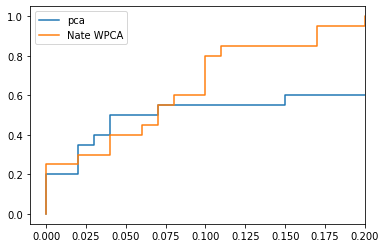

In [132]:


Wwpca = WPCA_L2(Xcenter.T, 2)


pca_errs = []
for i in range(len(X)):   
    x = Xcenter[[i],:]
    pca_errs.append(np.linalg.norm(x @ Wwpca @ Wwpca.T - x))

nwpca_preds = np.array(pca_errs)
nwpca_preds = nwpca_preds/np.max(nwpca_preds)

# plt.scatter(np.arange(len(wpca_preds)), nwpca_preds)
# plt.scatter(np.arange(len(wpca_preds)), labels)

plt.figure()
fpr, tpr, _ = roc_curve(labels, pca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'pca')

fpr, tpr, _ = roc_curve(labels, nwpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'Nate WPCA')

plt.legend()
plt.xlim([-.01,.2])

(-0.01, 0.2)

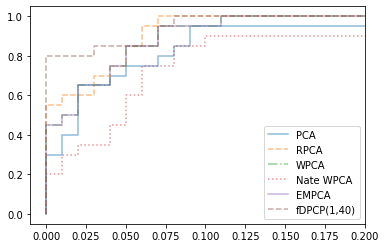

In [114]:
linestyles = ['solid', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted', (0, (3, 1, 1, 1)), (0, (5, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5, 2, 1, 2)), (0, (3, 1, 1, 1, 1, 1, 1, 1))]

ii=0
fpr, tpr, _ = roc_curve(labels, pca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'PCA', alpha = .5, linestyle = linestyles[ii])
ii+=1

# fpr, tpr, _ = roc_curve(labels, spca_preds, drop_intermediate=False)
# plt.plot(fpr, tpr, label = 'The PCA', alpha = .5, linestyle = linestyles[ii])
# ii+=1

fpr, tpr, _ = roc_curve(labels, rpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'RPCA', alpha = .5, linestyle = linestyles[ii])
ii+=1

fpr, tpr, _ = roc_curve(labels, wpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'WPCA', alpha = .5, linestyle = linestyles[ii])
ii+=1

fpr, tpr, _ = roc_curve(labels, nwpca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'Nate WPCA', alpha = .5, linestyle = linestyles[ii])
ii+=1

fpr, tpr, _ = roc_curve(labels, empca_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'EMPCA', alpha = .5, linestyle = linestyles[ii])
ii+=1

fpr, tpr, _ = roc_curve(labels, dpcp_preds, drop_intermediate=False)
plt.plot(fpr, tpr, label = 'fDPCP(1,40)', alpha = .5, linestyle = linestyles[ii])
ii+=1

plt.legend()
plt.xlim([-.01,.2])